# [Customer Lifetime Value](https://www.pymc-marketing.io/en/stable/guide/clv/clv_intro.html)



In [6]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arviz.labels import MapLabeller

from pymc_marketing import clv
from sklearn import preprocessing 

## 1.1 Data Requirements

For all models, the following nomenclature is used:

- `customer_id` represents a unique identifier for each customer.
- 'frequency' represents the number of repeat purchases that a customer has made, i.e. one less than the total number of purchases.
- `T` represents a customer’s “age”, i.e. the duration between a customer’s first purchase and the end of the period of study.
- `recency` represents the timepoint when a customer made their most recent purchase. This is also equal to the duration between a customer’s first non-repeat purchase (usually time 0) and last purchase. If a customer has made only 1 purchase, their recency is 0;
- `monetary_value` represents the average value of a given customer’s repeat purchases. Customers who have only made a single purchase have monetary values of zero.

If working with raw transaction data, the `rfm_summary` function can be used to preprocess data for modeling:

In [89]:
cust_list = pd.read_excel('restricted/trustit/cust_list.xlsx', skiprows=4, engine='calamine')
existing_customers = cust_list.loc[
    cust_list['Company Role'].isin(['OEM', 'End-Account']), 'Company Name (CN)'
].unique()
orders = pd.read_csv('data/orders.csv')
orders = orders.loc[orders.AssignedCustomer.isin(existing_customers)]

label_encoder = preprocessing.LabelEncoder()
orders['custID'] = label_encoder.fit_transform(orders['AssignedCustomer'])
map_cust = {k:v for k, v in orders[['custID', 'AssignedCustomer']].drop_duplicates().values}
orders = orders.groupby(['PostDate', 'custID'])[['OR']].sum().reset_index()

In [78]:
rfm_data = clv.utils.rfm_summary(
    orders,
    customer_id_col='custID',
    monetary_value_col='OR',
    datetime_col='PostDate',
    time_unit = "W"
)
rfm_data

,customer_id,frequency,recency,T,monetary_value
0,0,17.0,52.0,78.0,0.000000
1,1,17.0,90.0,100.0,439603.466471
2,2,10.0,125.0,197.0,1917.698000
3,3,0.0,0.0,45.0,0.000000
4,4,0.0,0.0,43.0,0.000000
...,...,...,...,...,...
1347,1347,2.0,62.0,77.0,244955.155000
1348,1348,46.0,317.0,332.0,97060.070652
1349,1349,1.0,5.0,15.0,20918.180000
1350,1350,1.0,256.0,306.0,2969.190000


we plot the **recency** and **T** of the customers with the `plot_customer_exposure` function. We see a chunk rate 20% of customers haven’t made another purchase in a while.

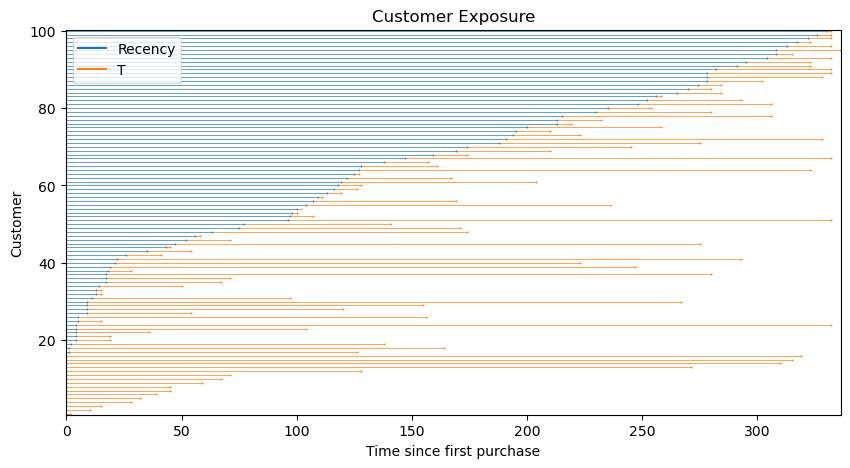

In [71]:
fig, ax = plt.subplots(figsize=(10, 5))
(
    rfm_data
    .sample(n=100, random_state=42)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

In [72]:
model_config = {
    'a_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'b_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'alpha_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'r_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
}
bgm = clv.BetaGeoModel(
    model_config = model_config,
    data = rfm_data
)
bgm.build_model()
bgm.fit()
bgm.fit_summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, alpha, r]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.407,0.052,0.314,0.501,0.001,0.001,2281.0,1913.0,1.0
alpha,10.883,0.594,9.799,11.989,0.013,0.009,2123.0,1836.0,1.0
b,6.524,1.387,3.997,8.876,0.030,0.021,2266.0,1995.0,1.0
r,1.148,0.054,1.049,1.250,0.001,0.001,2052.0,1590.0,1.0


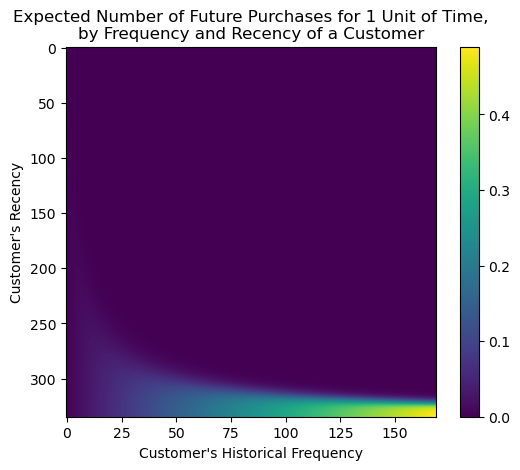

In [73]:
clv.plot_frequency_recency_matrix(bgm);

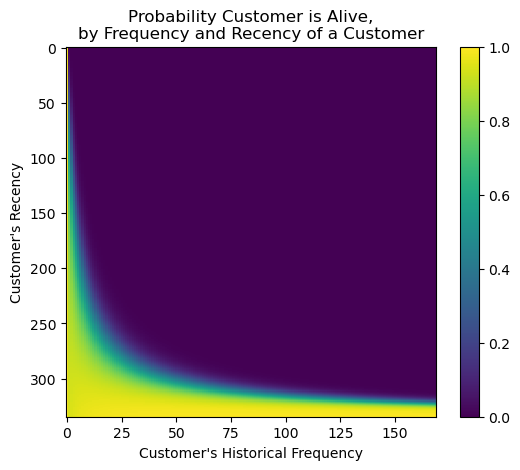

In [74]:
clv.plot_probability_alive_matrix(bgm);

In [90]:
num_purchases = bgm.expected_num_purchases(
    customer_id=rfm_data["customer_id"],
    t=1,
    frequency=rfm_data["frequency"],
    recency=rfm_data["recency"],
    T=rfm_data["T"]
)

sdata = rfm_data.copy()
sdata["expected_purchases"] = num_purchases.mean(("chain", "draw")).values
sdata['customer_name'] = sdata.customer_id.map(map_cust)
sdata.sort_values(by="expected_purchases").tail(10)


,customer_id,frequency,recency,T,monetary_value,expected_purchases,customer_name
1241,1241,81.0,256.0,258.0,5.157653e+04,0.302672,长春超维智能设备制造有限公司
452,452,36.0,97.0,99.0,5.909058e+04,0.331116,大连嘉源智能装备有限公司
436,436,48.0,121.0,127.0,1.195403e+06,0.333440,大连华锐重工集团股份有限公司
858,858,100.0,278.0,280.0,6.652339e+04,0.344826,沈阳真空技术研究所有限公司
118,118,105.0,282.0,284.0,3.727878e+04,0.357025,吉林奥拓自动化设备有限公司
511,511,168.0,326.0,332.0,1.476820e+05,0.471150,大连智云自动化装备股份有限公司
580,580,50.0,88.0,89.0,1.528491e+06,0.504963,大连豪森瑞德设备制造有限公司
668,668,161.0,262.0,263.0,5.749850e+05,0.589006,楚天华通医药设备有限公司
89,89,61.0,87.0,87.0,2.637440e+05,0.629876,华晨宝马汽车有限公司
264,264,76.0,79.0,80.0,-2.134361e+05,0.837320,哈尔滨宇龙智云科技有限公司
